In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import math
import random
import inspect
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('../data/text-1.txt', 'r', encoding='utf-8') as f:
    text = f.read().lower().replace('\n', ' ')

In [3]:
chars = sorted(set(text))

In [100]:
char2int = {c:i for i,c in enumerate(chars)}
# sot = '>'
# assert sot not in char2int
# char2int[sot] = 0
int2char = {i:c for c,i in char2int.items()}
numOfTokens = len(char2int)
print(f'{numOfTokens=}')
textInt = [char2int[ch] for ch in text]

numOfTokens=74


In [296]:
ctxLen = 10
def getSamples(trSamplNum=10, valSampleNum=None):
    # random.seed(123)
    valSampleNum = int(trSamplNum*0.3) if valSampleNum == None else valSampleNum
    idxs = random.sample(range(0,len(text)-ctxLen), trSamplNum+valSampleNum)
    X,Y = [],[]
    for i in idxs:
        X.append(textInt[i:i+ctxLen])
        Y.append(textInt[i+1:i+1+ctxLen])
    Xtr,Ytr = torch.tensor(X[:trSamplNum]), torch.tensor(Y[:trSamplNum])
    Xval,Yval = torch.tensor(X[trSamplNum:]), torch.tensor(Y[trSamplNum:])
    return ( Xtr,Ytr, Xval,Yval, )

In [383]:
class MlpPredictor(nn.Module):
    def __init__(self,numOfTokens,ctxLen,embSize):
        super().__init__()
        self.ctxLen = ctxLen
        self.embSize = embSize
        self.emb = nn.Embedding(numOfTokens,embSize)
        hidDim1 = 1000
        hidDim2 = 1000
        hidDim3 = 1000
        hidDim4 = 1000
        self.lin1 = nn.Linear(ctxLen*embSize,hidDim1)
        self.lin2 = nn.Linear(hidDim1,hidDim2)
        self.lin3 = nn.Linear(hidDim2,hidDim3)
        self.lin4 = nn.Linear(hidDim3,hidDim4)
        self.lin5 = nn.Linear(hidDim4,ctxLen*numOfTokens)
    def forward(self,x):
        x = self.emb(x).view(-1,self.ctxLen*self.embSize)

        x = self.lin1(x)
        x = F.leaky_relu(x)
        r1 = x

        x = self.lin2(x)
        x = F.leaky_relu(x)
        r2 = x

        x = self.lin3(x+r1)
        x = F.leaky_relu(x)
        r3 = x

        x = self.lin4(x+r2)
        x = F.leaky_relu(x)

        x = self.lin5(x+r3)
        
        x = x.view(-1,ctxLen,numOfTokens)
        return x
    @torch.no_grad()
    def generate(self,ctx,resLen):
        if len(ctx) < self.ctxLen:
            ctx = ' '*(ctxLen-len(ctx)) + ctx
        elif len(ctx) > self.ctxLen:
            ctx = ctx[-ctxLen:]
        res = []
        while len(res) < resLen:
            x = torch.tensor([char2int[ch] for ch in ctx]).unsqueeze(0)
            logits = self(x)[0,-1]
            probs = F.softmax(logits,dim=0)
            nextToken = torch.multinomial(probs, 1)
            nextChar = int2char[nextToken[0].item()]
            res.append(nextChar)
            ctx = ctx[1:] + nextChar
        return ''.join(res)

In [378]:
def print2dEmb(embLayer):
    W = embLayer.weight
    plt.figure(figsize=(8,8))
    plt.scatter(W[:,0].data,W[:,1].data,s=200)
    for i in range(W.shape[0]):
        plt.text(W[i,0].item(), W[i,1].item(), int2char[i], ha="center", va="center", color='white')
    plt.grid('minor')

def showParamsStats(model, layerNameFilter=None):
    plt.figure(figsize=(20,4))
    legends = []
    for pName, pValue in model.named_parameters():
        if layerNameFilter == None or layerNameFilter.match(pName):
            print(f'layer \'{pName}\'[{pValue.nelement()}] mean:{pValue.mean()}, std:{pValue.std()},')
            hy,hx = torch.histogram(pValue, density=True)
            plt.plot(hx[:-1].detach(),hy.detach(),)
            legends.append(pName)
    plt.legend(legends);
    

In [384]:
model = MlpPredictor(numOfTokens=numOfTokens,ctxLen=ctxLen,embSize=128)

numOfParams=9075692
layer 'lin1.weight'[3840000] mean:0.00035736264544539154, std:0.02850746549665928,
layer 'lin2.weight'[1000000] mean:-0.018322905525565147, std:0.030528685078024864,
layer 'lin3.weight'[1000000] mean:-0.0022779032588005066, std:0.028996501117944717,
layer 'lin4.weight'[1000000] mean:-0.011232100427150726, std:0.04977293685078621,
layer 'lin5.weight'[2220000] mean:-0.0064869350753724575, std:0.027250157669186592,


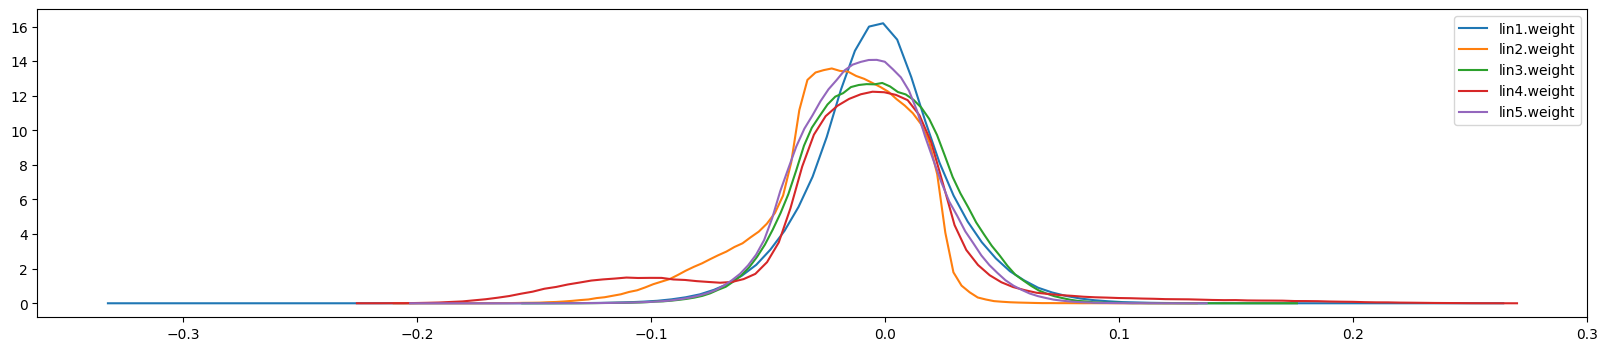

In [429]:
numOfParams = sum(p.nelement() for p in model.parameters())
print(f'{numOfParams=}')
showParamsStats(model,layerNameFilter=re.compile('^lin.*weight$'))
# print2dEmb(model.emb)

In [381]:
def calcLoss(model,X,Y):
    Yp = model(X)
    logits = Yp.view(-1,numOfTokens)
    targets = Y.view(-1)
    return F.cross_entropy(logits,targets)

In [428]:
model.generate('the',100)

' p iig t pfim,”o ricacbud anim.”  “ouenth an tovetol ingthtye thatetin tofiigun thnt be to mpot to f'

In [388]:
epochs_num = 10
batches_per_epoch = 100
batch_size = 128

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
for epoch in range(epochs_num):
    Xtr,Ytr, Xval,Yval = getSamples(trSamplNum=batches_per_epoch*batch_size)
    batch_idxs = [i for i in range(len(Xtr))[::batch_size]]
    random.shuffle(batch_idxs)
    for batch_begin in batch_idxs:
        batch_end = batch_begin+batch_size
        Xb = Xtr[batch_begin:batch_end]
        Yb = Ytr[batch_begin:batch_end]
        loss = calcLoss(model,Xb,Yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        trLoss = calcLoss(model,Xtr,Ytr)
        valLoss = calcLoss(model,Xval,Yval)
        print(f'epoch:{epoch}, trLoss={trLoss.item():.4f}, valLoss={valLoss.item():.4f}')

epoch:0, trLoss=0.5470, valLoss=0.7042
epoch:1, trLoss=0.1775, valLoss=0.2928
epoch:2, trLoss=0.1177, valLoss=0.1998
epoch:3, trLoss=0.1002, valLoss=0.1649
epoch:4, trLoss=0.0903, valLoss=0.1527
epoch:5, trLoss=0.0825, valLoss=0.1384
epoch:6, trLoss=0.0780, valLoss=0.1309
epoch:7, trLoss=0.0778, valLoss=0.1201
epoch:8, trLoss=0.0730, valLoss=0.1159
epoch:9, trLoss=0.0698, valLoss=0.1158
